In [12]:
# first, import all the libs we need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins

%matplotlib inline

df = pd.read_csv("crimes.csv")

# Crime Categories

We are not interested in using all the data because there are certain types of crimes that are irrelevant to immediate danger to another person. The crime alert should only notify a citizen nearby when he could be physically hurt or have his personal properties taken.

We are going to check the crime categories and filter out the ones that are not useful to us. Below are the crime categories.

In [2]:
for c in df.Category.unique():
    print c

WARRANTS
OTHER OFFENSES
LARCENY/THEFT
VEHICLE THEFT
VANDALISM
NON-CRIMINAL
ROBBERY
ASSAULT
WEAPON LAWS
BURGLARY
SUSPICIOUS OCC
DRUNKENNESS
FORGERY/COUNTERFEITING
DRUG/NARCOTIC
STOLEN PROPERTY
SECONDARY CODES
TRESPASS
MISSING PERSON
FRAUD
KIDNAPPING
RUNAWAY
DRIVING UNDER THE INFLUENCE
SEX OFFENSES FORCIBLE
PROSTITUTION
DISORDERLY CONDUCT
ARSON
FAMILY OFFENSES
LIQUOR LAWS
BRIBERY
EMBEZZLEMENT
SUICIDE
LOITERING
SEX OFFENSES NON FORCIBLE
EXTORTION
GAMBLING
BAD CHECKS
TREA
RECOVERED VEHICLE
PORNOGRAPHY/OBSCENE MAT


In [3]:
# These are the (what I believe to be) relevant crime categories:
relevant_categories = [
  "LARCENY/THEFT",
  "VEHICLE THEFT",
  "ROBBERY",
  "ASSAULT",
  "WEAPON LAWS",
  "BURGLARY",
  "DRUNKENNESS",
  "DRUG/NARCOTIC",
  "KIDNAPPING",
  "DRIVING UNDER THE INFLUENCE",
  "SEX OFFENSES FORCIBLE",
  "ARSON",
  "SEX OFFENSES NON FORCIBLE",
  "EXTORTION"
]

In [31]:
df = df[df.Category.isin(relevant_categories)]
print len(df)

df.groupby("Category").Category.value_counts().nlargest(5)

91198


Category                    
LARCENY/THEFT  LARCENY/THEFT    44564
ASSAULT        ASSAULT          14859
VEHICLE THEFT  VEHICLE THEFT     8119
BURGLARY       BURGLARY          7166
DRUG/NARCOTIC  DRUG/NARCOTIC     6837
dtype: int64

Above are the top 5 crimes. 3 out of 5 involve stealing other people's properties.
Assault is the second most common crime, which it is usually a way to get the victims to give the attackers their personal properties.

It appears San Francisco's main problem is related to stealing, which might have to do with the widening wealth gap in the city that comes with the tech boom. Many people can no longer afford to live in the city and there are a lot of homelessness.

# Time Relevance

Crimes that happened a long time ago are less relevant because the police might have taken measures to solve the problem or the people who committed crimes at these places are no longer around for various reasons).

I am going to include only the crimes that happened between 2013 and 2015.

# Neighborhoods

Let's take a look at where the crimes happened. This will be the part of the first crime alert component. The first component tells citizens where they should avoid by showing them the neighborhoods that have serious problems with crime.

In [5]:
neighborhoods = df.PdDistrict.unique()
df.groupby("PdDistrict").PdDistrict.value_counts().nlargest(len(neighborhoods))

PdDistrict            
SOUTHERN    SOUTHERN      18350
NORTHERN    NORTHERN      12520
MISSION     MISSION       11148
CENTRAL     CENTRAL       10748
BAYVIEW     BAYVIEW        7819
INGLESIDE   INGLESIDE      7702
TENDERLOIN  TENDERLOIN     6843
TARAVAL     TARAVAL        6009
RICHMOND    RICHMOND       5034
PARK        PARK           5025
dtype: int64

Much to my surprise, Tenderloin is not even close to the top of the list. It has an important implication. We cannot just take what people say about certain neighborhoods and we should look at facts. Now let's look at the crime distribution by coordinates.

In [6]:
map_osm = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

lats = df.X
lngs = df.Y
map_osm.add_children(plugins.HeatMap(zip(lngs, lats), radius = 10))

# map_osm.save("osm.html")

Looking at the heatmap, we can see that most crimes happened on the east side of the city. It means we should probably put more emphasis on that part by advising citizens to be there at times when crime rates are high and potentially give more real-time alerts to users when they are there.

# Days Of Week And Time

It is good to group the crimes by days of week and time during the day because it is almost always true that crimes happen more often during certain times in a day. It is uncertain whether the days of week matter but let's look at the statistics and see where it leads us.

Monday Crime Count 12599
Tuesday Crime Count 12233
Wednesday Crime Count 12897
Thursday Crime Count 12361
Friday Crime Count 14120
Saturday Crime Count 14012
Sunday Crime Count 12976


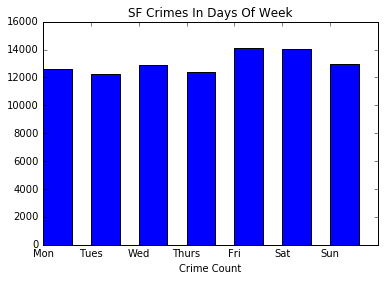

In [29]:
monday_crime = df[df.DayOfWeek == "Monday"]
tuesday_crime = df[df.DayOfWeek == "Tuesday"]
wednesday_crime = df[df.DayOfWeek == "Wednesday"]
thursday_crime = df[df.DayOfWeek == "Thursday"]
friday_crime = df[df.DayOfWeek == "Friday"]
saturday_crime = df[df.DayOfWeek == "Saturday"]
sunday_crime = df[df.DayOfWeek == "Sunday"]

print "Monday Crime Count {}".format(len(monday_crime))
print "Tuesday Crime Count {}".format(len(tuesday_crime))
print "Wednesday Crime Count {}".format(len(wednesday_crime))
print "Thursday Crime Count {}".format(len(thursday_crime))
print "Friday Crime Count {}".format(len(friday_crime))
print "Saturday Crime Count {}".format(len(saturday_crime))
print "Sunday Crime Count {}".format(len(sunday_crime))

days = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
crimes = [
    len(monday_crime),
    len(tuesday_crime),
    len(wednesday_crime),
    len(thursday_crime),
    len(friday_crime),
    len(saturday_crime),
    len(sunday_crime)
]

plt.bar(np.arange(7), crimes, width=.6, tick_label=days)
plt.xlabel("Crime Count")
plt.title("SF Crimes In Days Of Week")

It looks like the crime counts are evenly distributed during the days of week, with slightly more crimes happening on Friday and Saturday. A possible reason is more people go out during the weekends.

We did not really find any insights from the graph above, let's see if it makes a difference by segmenting the crimes by hours and days/hours.

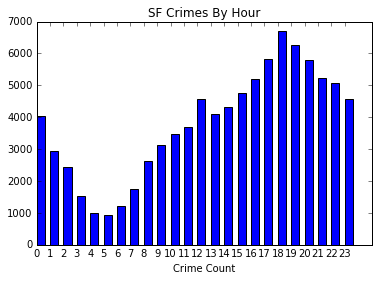

In [64]:
df.Hour = df.Dates.apply(lambda date: int(date.split(" ")[1].split(":")[0]))
crimes_by_hour = [len(df[df.Hour == hour]) for hour in np.arange(24)]
plt.bar(np.arange(24), crimes_by_hour, width=.6, tick_label=np.arange(24))
plt.xlabel("Crime Count")
plt.title("SF Crimes By Hour")

The statistics agrees with the traditional wisdom that there are more crimes when it is dark, with most of the crimes happening between 6PM and 12AM. Surprisingly, there are the most number of crimes between 6 and 7 PM but not later in the night. Let's take a look at what happened in that hour.

In [65]:
crimes_between_six_and_seven_pm = df[df.Hour == 18]
crimes_between_six_and_seven_pm.groupby("Category").Category.value_counts().nlargest(5)

Category                    
LARCENY/THEFT  LARCENY/THEFT    3776
ASSAULT        ASSAULT           796
VEHICLE THEFT  VEHICLE THEFT     697
DRUG/NARCOTIC  DRUG/NARCOTIC     480
BURGLARY       BURGLARY          461
dtype: int64

The result is consistent with general 